In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc

import os
import warnings
warnings.filterwarnings('ignore')

C:\Users\sid\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
dtypes={
    'ip':'uint16','app':'uint16','device':'uint16','os':'uint16','channel':'uint16','ips_attributed':'uint8','click_id':'uint32'
}


In [4]:
testing = True
if testing:
    train_path = "train_sample_talking_data/train_sample.csv"
    skiprows = None
    nrows = None
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
else:
    train_path = "train.csv"
    skiprows = range(1, 144903891)
    nrows = 10000000
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

train_sample = pd.read_csv(train_path, skiprows=skiprows, nrows=nrows, dtype=dtypes, usecols=colnames)


In [5]:
len(train_sample.index)

100000

In [6]:
print(train_sample.memory_usage())

Index               128
ip               200000
app              200000
device           200000
os               200000
channel          200000
click_time       800000
is_attributed    800000
dtype: int64


In [7]:
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 2.47967529296875 MB


In [8]:
train_sample.head()

,ip,app,device,os,channel,click_time,is_attributed
0,22004,12,1,13,497,2017-11-07 09:30:38,0
1,40024,25,1,17,259,2017-11-07 13:40:27,0
2,35888,12,1,19,212,2017-11-07 18:05:24,0
3,29048,13,1,13,477,2017-11-07 04:58:08,0
4,2877,12,1,1,178,2017-11-09 09:00:09,0


In [9]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
ip               100000 non-null uint16
app              100000 non-null uint16
device           100000 non-null uint16
os               100000 non-null uint16
channel          100000 non-null uint16
click_time       100000 non-null object
is_attributed    100000 non-null int64
dtypes: int64(1), object(1), uint16(5)
memory usage: 2.5+ MB


In [10]:
def fraction_unique(x):
    return len(train_sample[x].unique())
number_unique_vals={x:fraction_unique(x) for x in train_sample.columns}

In [11]:
number_unique_vals

{'ip': 28470,
 'app': 161,
 'device': 100,
 'os': 130,
 'channel': 161,
 'click_time': 80350,
 'is_attributed': 2}

In [12]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
click_time       object
is_attributed     int64
dtype: object

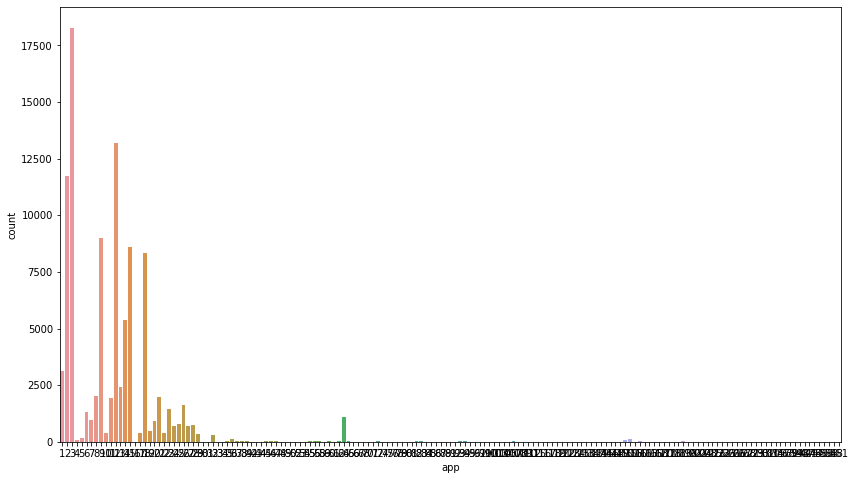

In [13]:
plt.figure(figsize=(14, 8))
sns.countplot(x="app", data=train_sample)

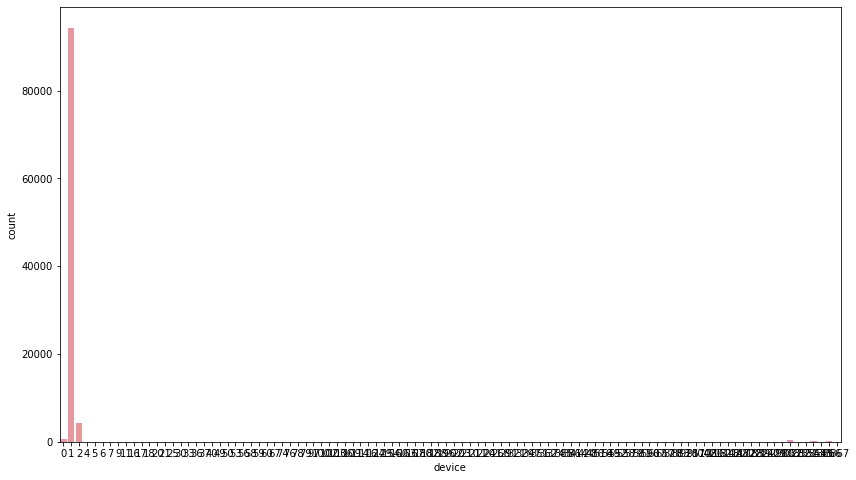

In [14]:
plt.figure(figsize=(14, 8))
sns.countplot(x="device", data=train_sample)

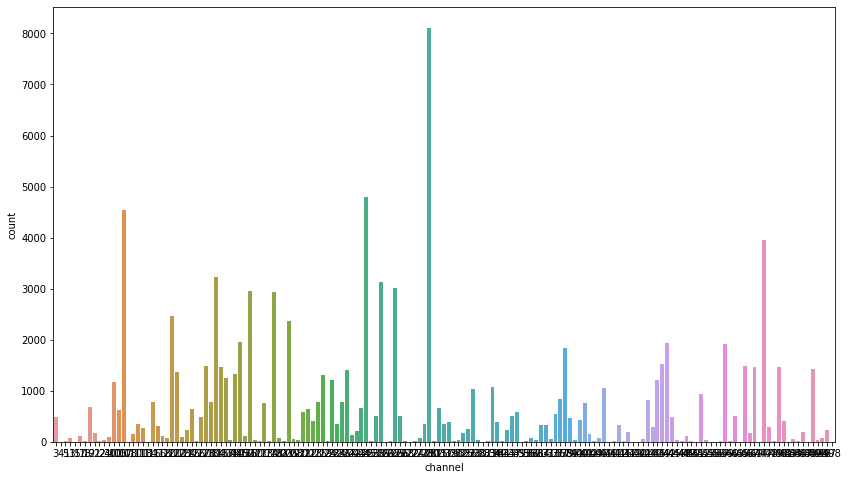

In [15]:
plt.figure(figsize=(14, 8))
sns.countplot(x="channel", data=train_sample)

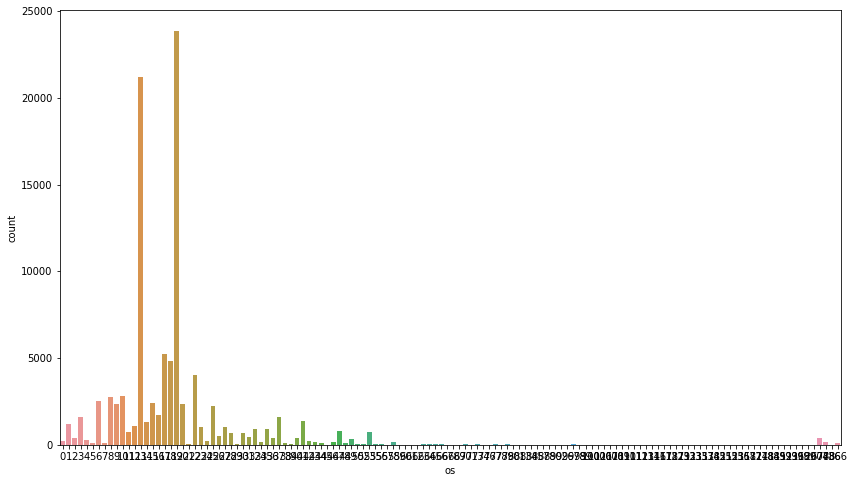

In [16]:
plt.figure(figsize=(14, 8))
sns.countplot(x="os", data=train_sample)

In [17]:
100*(train_sample['is_attributed'].astype('object').value_counts()/len(train_sample.index))

0    99.773
1     0.227
Name: is_attributed, dtype: float64

In [18]:
app_target = train_sample.groupby('app').is_attributed.agg(['mean', 'count'])
app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


In [19]:
frequent_apps=train_sample.groupby('app').size().reset_index(name='count')
frequent_apps=frequent_apps[frequent_apps['count']>frequent_apps['count'].quantile(0.80)]
frequent_apps=frequent_apps.merge(train_sample,on='app',how='inner')
frequent_apps.head()

,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,0
2,1,3135,23706,1,27,124,2017-11-07 09:37:21,0
3,1,3135,58458,1,19,101,2017-11-09 14:27:57,0
4,1,3135,34067,1,15,134,2017-11-07 15:06:06,0


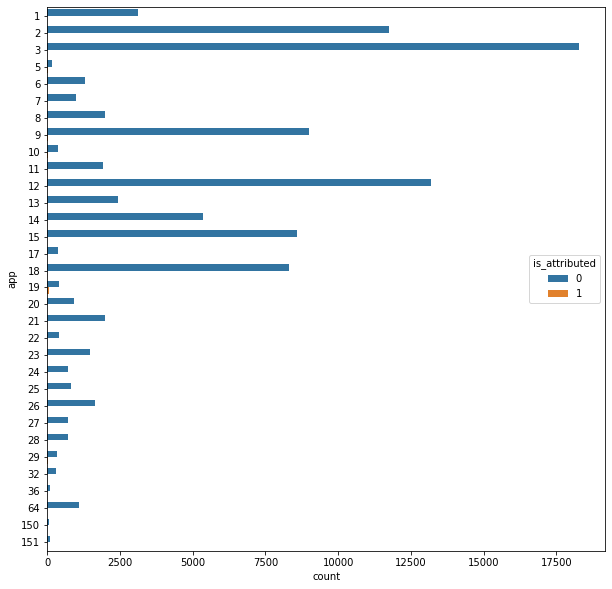

In [20]:
plt.figure(figsize=(10,10))
sns.countplot(y="app", hue="is_attributed", data=frequent_apps);

In [21]:
def time_features(df):
    df['datetime']=pd.to_datetime(df['click_time'])
    df['day_of_week']=df['datetime'].dt.dayofweek
    df['day_of_year']=df['datetime'].dt.dayofyear
    df['month']=df['datetime'].dt.month
    df['hour']=df['datetime'].dt.hour
    return df
    

In [22]:
train_sample=time_features(train_sample)
train_sample.drop(['click_time', 'datetime'], axis=1, inplace=True)
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


In [23]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     int64
day_of_week       int64
day_of_year       int64
month             int64
hour              int64
dtype: object

In [24]:
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 4.76849365234375 MB


In [25]:
int_vars = ['app', 'device', 'os', 'channel', 'day_of_week','day_of_year', 'month', 'hour']
train_sample[int_vars]=train_sample[int_vars].astype('uint16')

In [26]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     int64
day_of_week      uint16
day_of_year      uint16
month            uint16
hour             uint16
dtype: object

In [27]:
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 2.47967529296875 MB


In [28]:
ip_count = train_sample.groupby('ip').size().reset_index(name='ip_count').astype('int16')
ip_count.head()

,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1
4,16,6


In [29]:
# creates groupings of IP addresses with other features and appends the new features to the df
def grouped_features(df):
    # ip_count
    ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('uint16')
    ip_day_hour = df.groupby(['ip', 'day_of_week', 'hour']).size().reset_index(name='ip_day_hour').astype('uint16')
    ip_hour_channel = df[['ip', 'hour', 'channel']].groupby(['ip', 'hour', 'channel']).size().reset_index(name='ip_hour_channel').astype('uint16')
    ip_hour_os = df.groupby(['ip', 'hour', 'os']).channel.count().reset_index(name='ip_hour_os').astype('uint16')
    ip_hour_app = df.groupby(['ip', 'hour', 'app']).channel.count().reset_index(name='ip_hour_app').astype('uint16')
    ip_hour_device = df.groupby(['ip', 'hour', 'device']).channel.count().reset_index(name='ip_hour_device').astype('uint16')
    
    # merge the new aggregated features with the df
    df = pd.merge(df, ip_count, on='ip', how='left')
    del ip_count
    df = pd.merge(df, ip_day_hour, on=['ip', 'day_of_week', 'hour'], how='left')
    del ip_day_hour
    df = pd.merge(df, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')
    del ip_hour_channel
    df = pd.merge(df, ip_hour_os, on=['ip', 'hour', 'os'], how='left')
    del ip_hour_os
    df = pd.merge(df, ip_hour_app, on=['ip', 'hour', 'app'], how='left')
    del ip_hour_app
    df = pd.merge(df, ip_hour_device, on=['ip', 'hour', 'device'], how='left')
    del ip_hour_device
    
    return df

In [30]:
train_sample = grouped_features(train_sample)
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,22004,12,1,13,497,0,1,311,11,9,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,311,11,13,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,311,11,18,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,311,11,4,3,1,1,1,1,1
4,2877,12,1,1,178,0,3,313,11,9,4,1,1,1,1,1


In [31]:
gc.collect()

110017

In [32]:
X = train_sample.drop('is_attributed', axis=1)
y = train_sample[['is_attributed']]


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80000, 15)
(80000, 1)
(20000, 15)
(20000, 1)


In [34]:
print(y_train.mean())
print(y_test.mean())

is_attributed    0.002275
dtype: float64
is_attributed    0.00225
dtype: float64


In [35]:
tree=DecisionTreeClassifier(max_depth=2)

adaboost_model_1=AdaBoostClassifier(
    base_estimator=tree,
    n_estimators=600,
    learning_rate=1.54,
    algorithm="SAMME")

In [37]:
adaboost_model_1.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                               

In [38]:
predictions=adaboost_model_1.predict_proba(X_test)
predictions[:10]

array([[0.52754154, 0.47245846],
       [0.52782059, 0.47217941],
       [0.52726318, 0.47273682],
       [0.52136281, 0.47863719],
       [0.51077464, 0.48922536],
       [0.52372269, 0.47627731],
       [0.51807211, 0.48192789],
       [0.5273349 , 0.4726651 ],
       [0.52421345, 0.47578655],
       [0.50989225, 0.49010775]])

In [39]:
metrics.roc_auc_score(y_test,predictions[:,1])

0.9436242657089562

In [40]:
param_grid={"base_estimator__max_depth":[2,5],
           "n_estimators":[200,400,600]
           }

In [41]:
tree=DecisionTreeClassifier()
ABC=AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    algorithm="SAMME")

In [42]:
folds=3
grid_search_ABC=GridSearchCV(ABC,
                            cv=folds,
                            param_grid=param_grid,
                            scoring='roc_auc',
                            return_train_score=True,
                            verbose=1)

In [43]:
grid_search_ABC.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 10.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
                                                                                mi

In [44]:
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,10.973121,0.125772,0.495568,0.008997,2,200,"{'base_estimator__max_depth': 2, 'n_estimators...",0.926966,0.975725,0.955801,0.952831,0.020017,1,0.996306,0.995094,0.996461,0.995954,6.111043e-04
1,21.291049,0.486196,0.972307,0.002009,2,400,"{'base_estimator__max_depth': 2, 'n_estimators...",0.920643,0.974585,0.956496,0.950575,0.022416,2,0.997991,0.996683,0.997996,0.997556,6.179779e-04
2,31.603392,0.282549,1.397142,0.070959,2,600,"{'base_estimator__max_depth': 2, 'n_estimators...",0.921720,0.973335,0.953955,0.949670,0.021288,3,0.998494,0.997923,0.998417,0.998278,2.530744e-04
3,22.437934,0.582208,0.581683,0.006290,5,200,"{'base_estimator__max_depth': 5, 'n_estimators...",0.904268,0.943041,0.937687,0.928332,0.017155,4,1.000000,1.000000,1.000000,1.000000,0.000000e+00
4,44.798113,0.206316,1.035757,0.112684,5,400,"{'base_estimator__max_depth': 5, 'n_estimators...",0.892687,0.938901,0.935258,0.922282,0.020980,5,1.000000,1.000000,1.000000,1.000000,0.000000e+00
5,67.594250,1.267152,1.689152,0.003315,5,600,"{'base_estimator__max_depth': 5, 'n_estimators...",0.882412,0.925743,0.934267,0.914141,0.022704,6,1.000000,1.000000,1.000000,1.000000,6.409876e-17


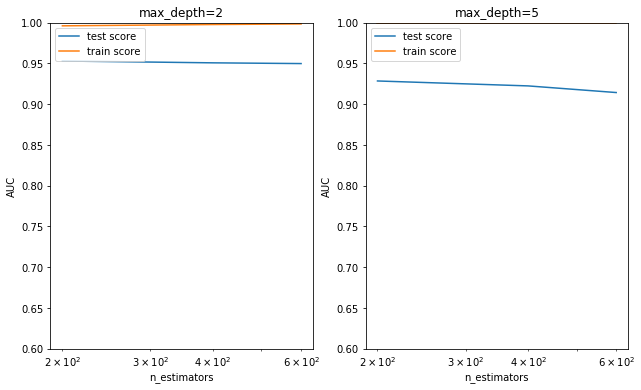

In [46]:
# plotting AUC with hyperparameter combinations

plt.figure(figsize=(16,6))
for n, depth in enumerate(param_grid['base_estimator__max_depth']):
    

    # subplot 1/n
    plt.subplot(1,3, n+1)
    depth_df = cv_results[cv_results['param_base_estimator__max_depth']==depth]

    plt.plot(depth_df["param_n_estimators"], depth_df["mean_test_score"])
    plt.plot(depth_df["param_n_estimators"], depth_df["mean_train_score"])
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')
    plt.title("max_depth={0}".format(depth))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

    


In [47]:
tree = DecisionTreeClassifier(max_depth=2)
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    n_estimators=200,
    algorithm="SAMME")

ABC.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                               

In [48]:
predictions = ABC.predict_proba(X_test)
predictions[:10]

array([[0.5880972 , 0.4119028 ],
       [0.58960261, 0.41039739],
       [0.60708804, 0.39291196],
       [0.57134614, 0.42865386],
       [0.55591021, 0.44408979],
       [0.58624788, 0.41375212],
       [0.56320517, 0.43679483],
       [0.58981139, 0.41018861],
       [0.59090843, 0.40909157],
       [0.56433022, 0.43566978]])

In [49]:
metrics.roc_auc_score(y_test, predictions[:, 1])

0.9478933155154654

In [50]:
param_grid = {"learning_rate": [0.2, 0.6, 0.9],
              "subsample": [0.3, 0.6, 0.9]
             }

In [51]:
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200)

In [52]:
folds = 3
grid_search_GBC = GridSearchCV(GBC, 
                               cv = folds,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

grid_search_GBC.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=2,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=200,
                                                  n_iter_no_change=None,
                                                  presort=

In [53]:
cv_results = pd.DataFrame(grid_search_GBC.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,4.738364,0.336674,0.044605,6.541753e-03,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.723069,0.835294,0.852419,0.803594,0.057368,2,0.776261,0.815764,0.805160,0.799061,0.016694
1,5.870259,0.101762,0.039991,1.713999e-05,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.726013,0.803213,0.834437,0.787887,0.045571,3,0.643954,0.791773,0.798819,0.744849,0.071401
2,4.825033,0.037586,0.044974,9.602742e-07,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.909600,0.825903,0.792609,0.842705,0.049217,1,0.932409,0.817726,0.772793,0.840976,0.067205
3,4.880030,0.083711,0.043322,2.360217e-03,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.633870,0.677789,0.598073,0.636578,0.032600,5,0.590745,0.716363,0.711130,0.672746,0.058023
4,5.976049,0.043529,0.040161,2.953416e-04,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.202525,0.622479,0.622039,0.482346,0.197865,7,0.228377,0.653616,0.628461,0.503485,0.194801


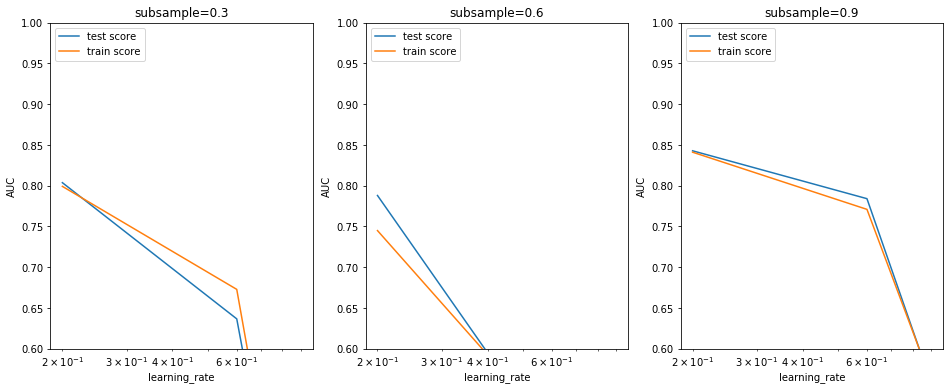

In [54]:
plt.figure(figsize=(16,6))


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')


In [55]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [56]:
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[9.9999809e-01, 1.9337567e-06],
       [9.9998653e-01, 1.3449854e-05],
       [9.9997407e-01, 2.5916344e-05],
       [9.9952990e-01, 4.7011764e-04],
       [9.9978644e-01, 2.1357677e-04],
       [9.9999368e-01, 6.3347384e-06],
       [9.9991673e-01, 8.3290950e-05],
       [9.9998868e-01, 1.1305605e-05],
       [9.9981380e-01, 1.8618918e-04],
       [9.9910051e-01, 8.9947641e-04]], dtype=float32)

In [57]:
roc = metrics.roc_auc_score(y_test, y_pred[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 96.06%


In [58]:
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      



In [59]:
model_cv.fit(X_train, y_train)       

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsampl

In [62]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.584795,0.345558,0.063776,0.005601,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.914064,0.971373,0.962963,0.949467,0.025268,3,0.990450,0.984303,0.988183,0.987645,0.002538
1,4.249583,0.177824,0.063386,0.013989,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.926961,0.973582,0.961443,0.953995,0.019748,1,0.994016,0.986355,0.992693,0.991021,0.003343
2,4.185307,0.186418,0.060915,0.008407,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.924236,0.975867,0.951012,0.950372,0.021083,2,0.992880,0.989807,0.993936,0.992208,0.001752
3,4.234058,0.089347,0.062245,0.010288,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.885865,0.957231,0.940434,0.927843,0.030465,6,0.997522,0.991143,0.993425,0.994030,0.002639
4,3.975807,0.072764,0.062720,0.007346,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.893749,0.967978,0.955700,0.939142,0.032487,5,0.999624,0.997823,0.998964,0.998804,0.000744
5,3.844564,0.069476,0.062273,0.006128,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.923785,0.975658,0.947313,0.948919,0.021207,4,0.999633,0.999070,0.999660,0.999454,0.000272


In [64]:

cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.584795,0.345558,0.063776,0.005601,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.914064,0.971373,0.962963,0.949467,0.025268,3,0.990450,0.984303,0.988183,0.987645,0.002538
1,4.249583,0.177824,0.063386,0.013989,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.926961,0.973582,0.961443,0.953995,0.019748,1,0.994016,0.986355,0.992693,0.991021,0.003343
2,4.185307,0.186418,0.060915,0.008407,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.924236,0.975867,0.951012,0.950372,0.021083,2,0.992880,0.989807,0.993936,0.992208,0.001752
3,4.234058,0.089347,0.062245,0.010288,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.885865,0.957231,0.940434,0.927843,0.030465,6,0.997522,0.991143,0.993425,0.994030,0.002639
4,3.975807,0.072764,0.062720,0.007346,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.893749,0.967978,0.955700,0.939142,0.032487,5,0.999624,0.997823,0.998964,0.998804,0.000744


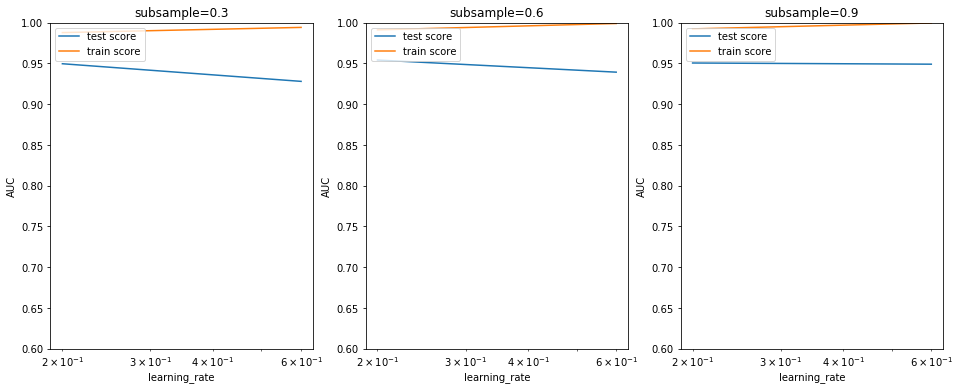

In [65]:
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [66]:
params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic',
              params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.6},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

In [67]:
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[9.9999809e-01, 1.9337567e-06],
       [9.9998653e-01, 1.3449854e-05],
       [9.9997407e-01, 2.5916344e-05],
       [9.9952990e-01, 4.7011764e-04],
       [9.9978644e-01, 2.1357677e-04],
       [9.9999368e-01, 6.3347384e-06],
       [9.9991673e-01, 8.3290950e-05],
       [9.9998868e-01, 1.1305605e-05],
       [9.9981380e-01, 1.8618918e-04],
       [9.9910051e-01, 8.9947641e-04]], dtype=float32)

In [68]:
auc = sklearn.metrics.roc_auc_score(y_test, y_pred[:, 1])
auc

0.9606303070798186

In [69]:
importance = dict(zip(X_train.columns, model.feature_importances_))
importance

{'ip': 0.04728199,
 'app': 0.17046946,
 'device': 0.22968191,
 'os': 0.081967376,
 'channel': 0.15076274,
 'day_of_week': 0.05127022,
 'day_of_year': 0.0,
 'month': 0.0,
 'hour': 0.049176194,
 'ip_count': 0.07210487,
 'ip_day_hour': 0.042323995,
 'ip_hour_channel': 0.0,
 'ip_hour_os': 0.04077013,
 'ip_hour_app': 0.026437322,
 'ip_hour_device': 0.03775376}

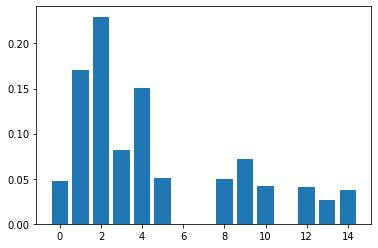

In [70]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()